In [91]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib as mpl
mpl.rc('figure', figsize=(16,8))
import matplotlib.pyplot as plt
import os
import glob
import re
import pims
import tifffile
import trackpy as tp

Get list of files in the directory

In [92]:
#files = np.sort(glob.glob(os.path.join(os.getcwd(), 'proc', '*.tif')))
path = '../data/exp_raw/2023-07-29_12B09/'
files = np.sort(glob.glob(os.path.join(path, 'tile*_bp.tif')))
xyfiles = np.sort(glob.glob(os.path.join(path, 'xy*.dat')))
pattern = re.compile(r'\d+.*.tif')
files

array(['../data/exp_raw/2023-07-29_12B09/tile_01_bp.tif',
       '../data/exp_raw/2023-07-29_12B09/tile_02_bp.tif',
       '../data/exp_raw/2023-07-29_12B09/tile_03_bp.tif',
       '../data/exp_raw/2023-07-29_12B09/tile_04_bp.tif',
       '../data/exp_raw/2023-07-29_12B09/tile_05_bp.tif',
       '../data/exp_raw/2023-07-29_12B09/tile_06_bp.tif',
       '../data/exp_raw/2023-07-29_12B09/tile_07_bp.tif',
       '../data/exp_raw/2023-07-29_12B09/tile_08_bp.tif',
       '../data/exp_raw/2023-07-29_12B09/tile_09_bp.tif'], dtype='<U47')

## Preliminary analysis

Use one of the files to find optimal parameters for analysis

In [93]:
j = 4
file = files[j]
fname = pattern.findall(file)[0]
print('Analysing ', fname, '...')
x1, x2, y1, y2 = np.fromfile(xyfiles[j], sep='\n')
print('x: ', x1, x2)
print('y: ', y1, y2)

Analysing  2023-07-29_12B09/tile_05_bp.tif ...
x:  -5542.6 -2227.6
y:  3732.5 7054.0


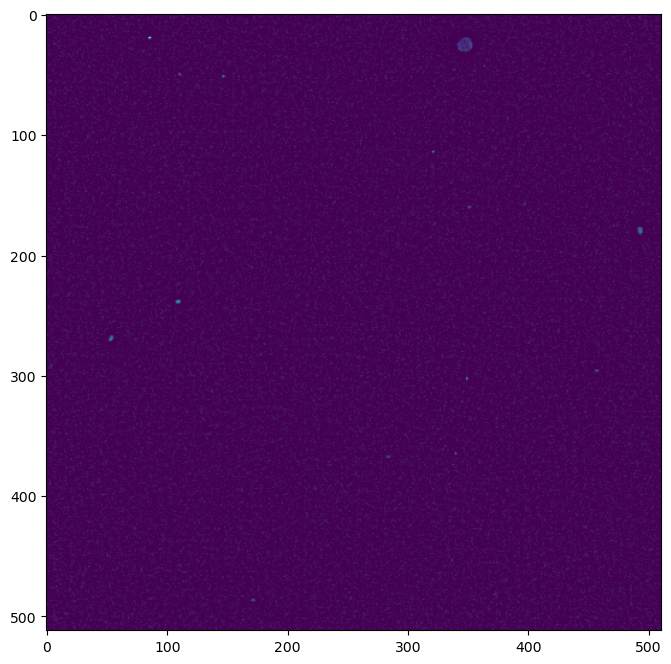

In [94]:
# Read frames
# frames = ND2Reader(file)
frames = tifffile.imread(file)
# Show a sample frame
plt.imshow(frames[-0]);

Locate features

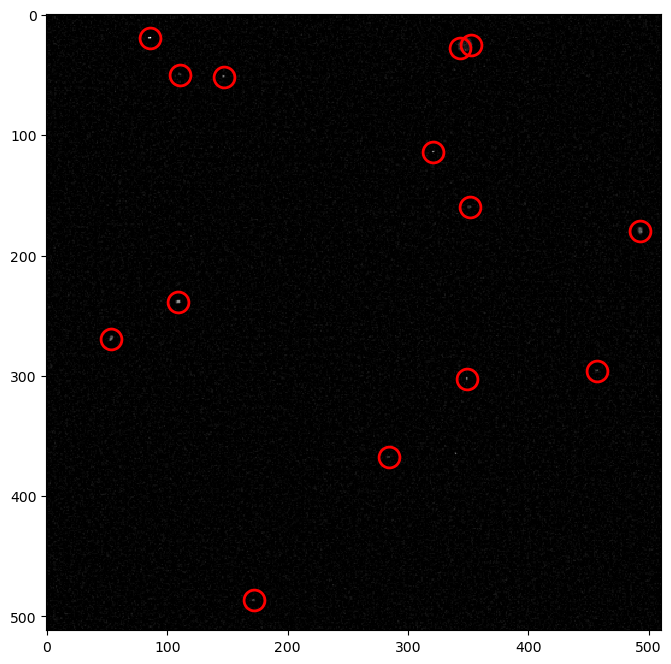

In [95]:
size = 7 # px
minmass = 67
maxsize = 15 # px
f = tp.locate(frames[0], size, minmass=minmass, maxsize=maxsize)
tp.annotate(f, frames[0]);

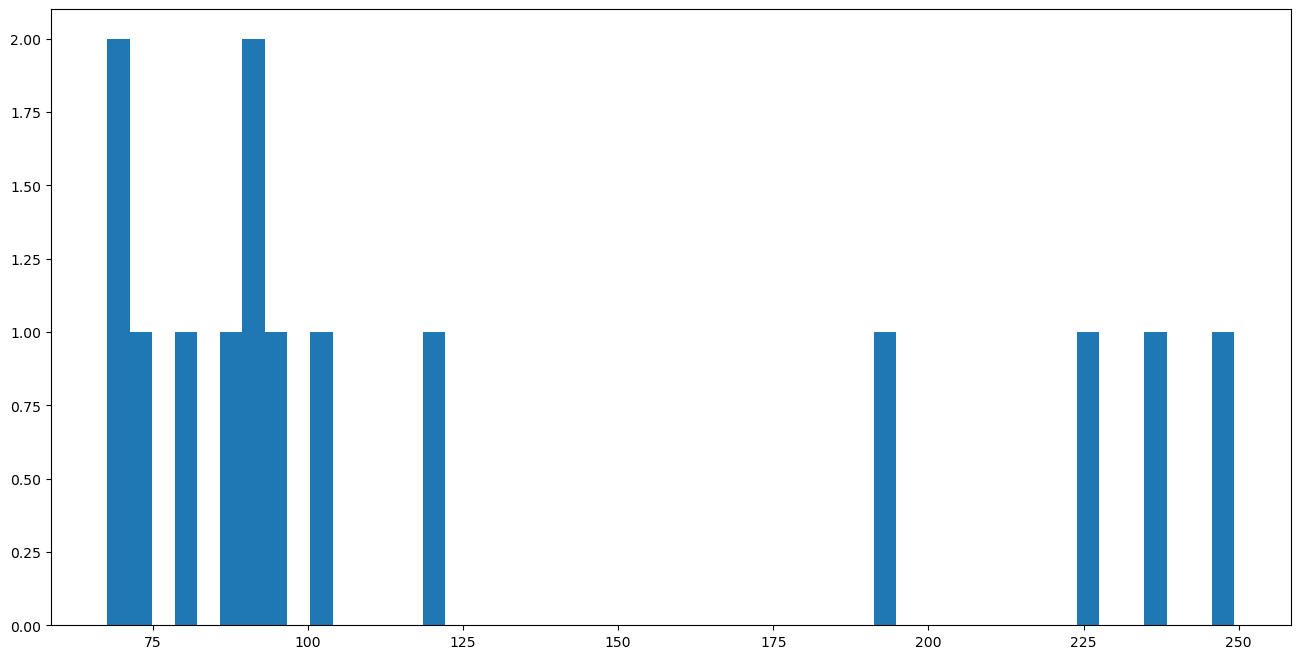

In [96]:
plt.hist(f['mass'], bins=50);

/home/riccardo/miniforge3/envs/tracking/lib/python3.11/site-packages/trackpy/plots.py:638: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  axlist = f[pos_columns].applymap(lambda x: x % 1).hist()


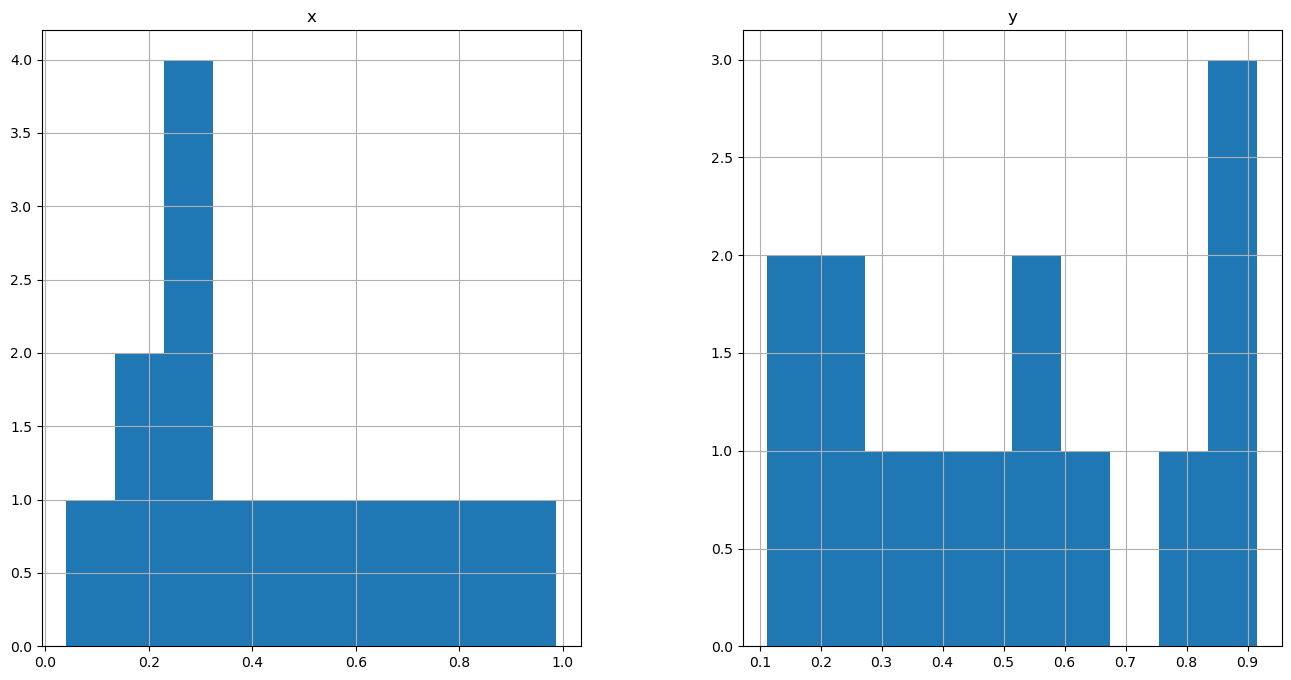

In [97]:
tp.subpx_bias(f);

## Tracking

In [98]:
max_displacement = 60 # px
memory = 3 # frames
f = tp.batch(frames[0:30], size, minmass=minmass, maxsize=maxsize)
t = tp.link_df(f, max_displacement, memory=memory)

Frame 29: 10 trajectories present.


In [101]:
min_duration = 0 # frames
tf = tp.filter_stubs(t, min_duration)
print('Raw:', t['particle'].nunique(), 'trajectories')
print('Filtered:', tf['particle'].nunique(), 'trajectories')

Raw: 17 trajectories
Filtered: 17 trajectories


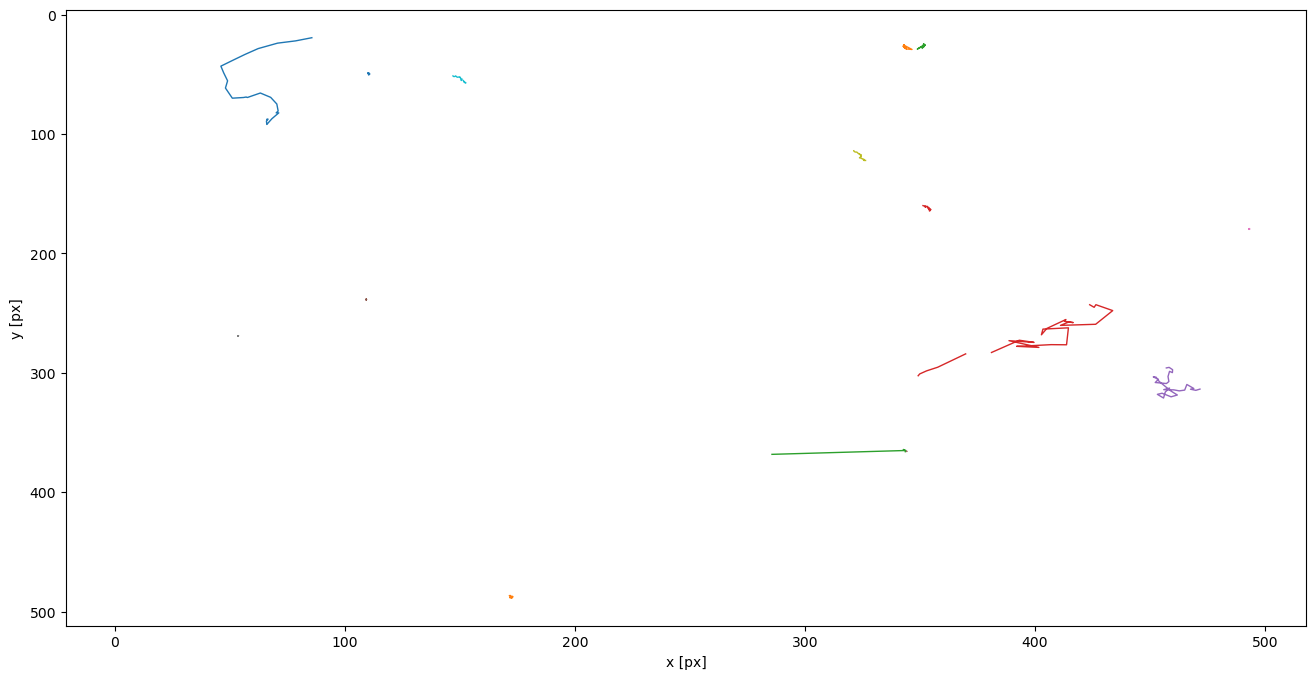

In [102]:
tp.plot_traj(tf);

In [103]:
f

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,19.233029,85.624021,192.220039,1.262277,0.277938,31.994850,369.0,0.036588,0
1,25.112277,352.215110,119.572909,1.752228,0.248293,10.539480,474.0,0.028085,0
2,27.776581,343.476447,93.224210,1.798758,0.222760,8.406490,358.0,0.037787,0
3,49.580645,110.790323,70.012260,1.352682,0.180379,9.661190,147.0,0.101684,0
4,51.240163,146.987788,92.471390,1.243709,0.262442,15.307340,189.0,0.076077,0
...,...,...,...,...,...,...,...,...,...
364,179.713895,493.290212,245.817014,1.656299,0.165413,22.545845,669.0,0.018921,29
365,238.560641,109.218154,220.579127,1.393567,0.232858,29.275948,476.0,0.026918,29
366,269.011504,53.512736,204.763385,1.536999,0.149749,23.050603,471.0,0.027216,29
367,313.613065,471.809045,100.446788,1.351840,0.203907,14.301469,213.0,0.063479,29


## Identify blobs and merge tiles

In [109]:
d = [f for i in range(len(files))] # dummy list of dataframes
for i in range(len(files)):
    x1, x2, y1, y2 = np.fromfile(xyfiles[i], sep='\n')
    frames = tifffile.imread(files[i])
    ny, nx = frames[0].shape
    size = 7 # px
    minmass = 67
    maxsize = 15 # px
    f = tp.batch(frames, size, minmass=minmass, maxsize=maxsize)
    itp_x = lambda x: x1 + x/(nx-1) * (x2-x1)
    itp_y = lambda y: y1 + y/(ny-1) * (y2-y1)
    # inverted dimensions in trackpy
    f['y'] = f['y'].apply(itp_y)
    f['x'] = f['x'].apply(itp_x)
    d[i] = f

df = pd.concat(d)

Frame 74: 6 features


KeyboardInterrupt: 

## Track over entire domain

In [ ]:
max_displacement = 60*6.5 # μm
memory = 3 # frames
t = tp.link_df(df, max_displacement, memory=memory)
min_duration = 150 # frames
tf = tp.filter_stubs(t, min_duration)
print('Raw:', t['particle'].nunique(), 'trajectories')
print('Filtered:', tf['particle'].nunique(), 'trajectories')

In [ ]:
tp.plot_traj(tf);

In [108]:
tf.to_pickle(os.path.join(path, 'tracks_bp.pkl'))